# An-Cockrell model reimplementation



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools

import an_cockrell

In [2]:
model = an_cockrell.AnCockrellModel(
    GRID_WIDTH=50,
    GRID_HEIGHT=50,
    BAT=False,
    INIT_DCS=50,
    INIT_MACROS=50,
    INIT_NKS=25,
)

* Blue Squares = Healthy Epithelial Cells
* Yellow Squares = Infected Epithelial Cells
* Grey Squares = Epithelial Cells killed by necrosis
* Grey Pentagons = Epithelial Cells killed by apoptosis
* Green Circles = Macrophages
* Large Green Circles = Macrophages at phagocytosis limit
* Orange Circles = NK Cells
* Light Blue Triangles = Dendritic Cells
* Pink Square Outlines = Activated Endothelial Cells
* Small White Circles = PMNs

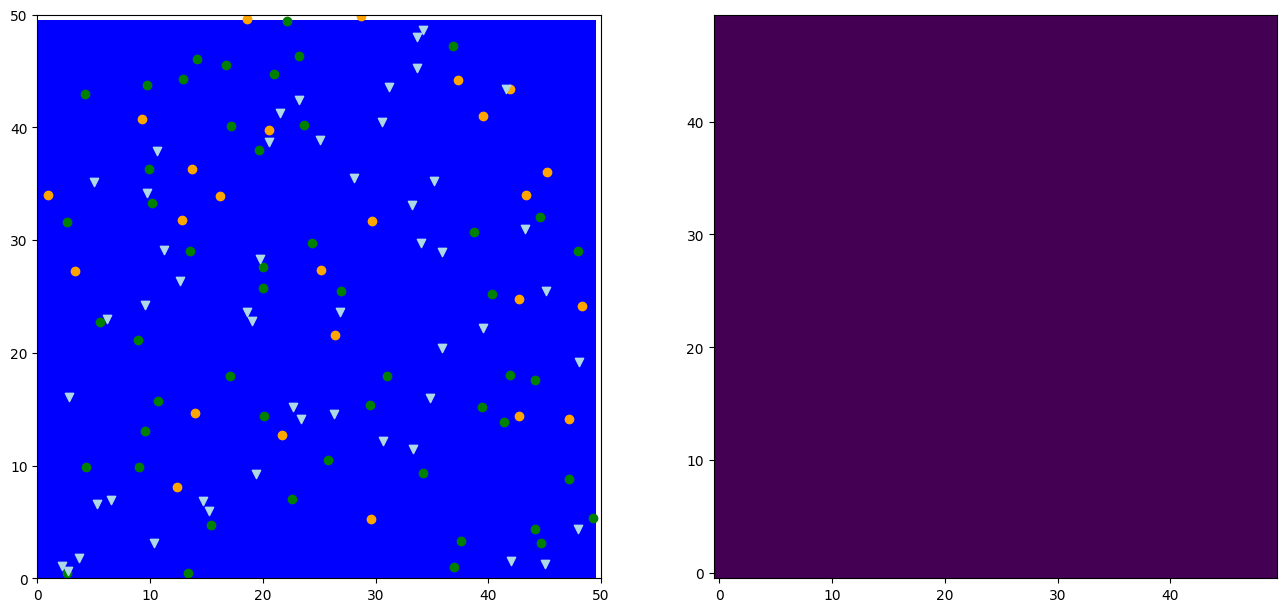

In [3]:

fig, axs = plt.subplots(1, 2,figsize=(16,8))

model.plot_agents(axs[0])
model.plot_field(axs[1], field_name='extracellular_virus')


axs[0].set_aspect(1)
axs[1].set_aspect(1)

In [4]:
model.infect(init_inoculum=150) # Initial-inoculum from 25-150 increments of 25, run for 14 days (2016 steps)

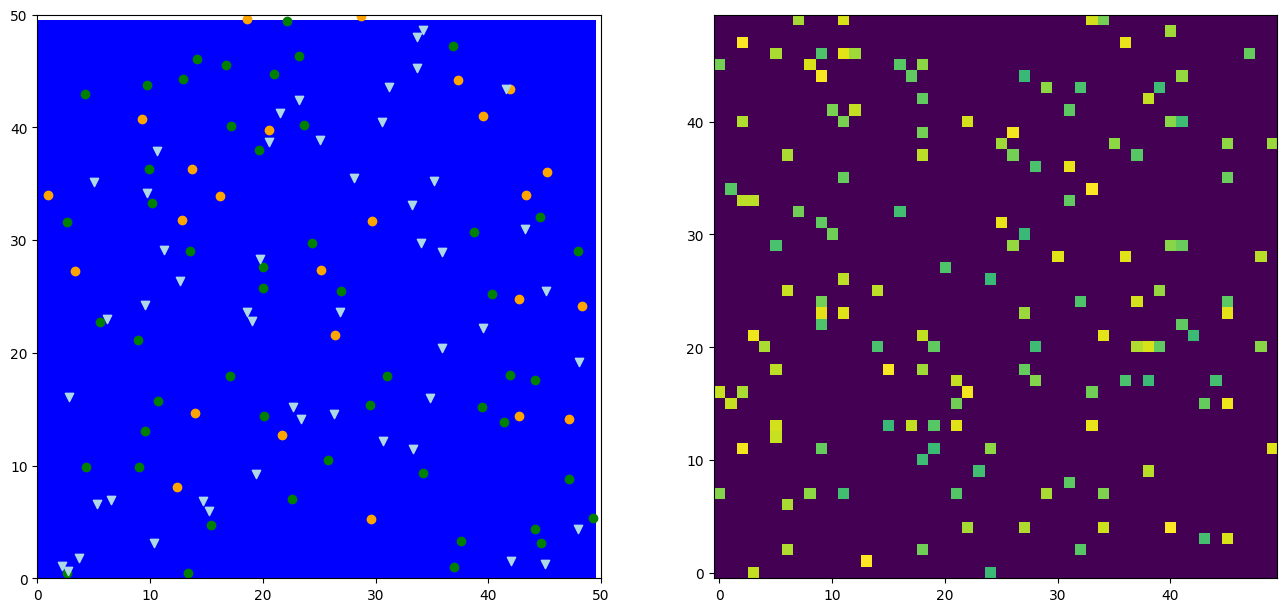

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(16,8))

model.plot_agents(axs[0])
model.plot_field(axs[1], field_name='extracellular_virus')


axs[0].set_aspect(1)
axs[1].set_aspect(1)

In [6]:
model.time_step()

/tmp/ipykernel_527449/1192103216.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


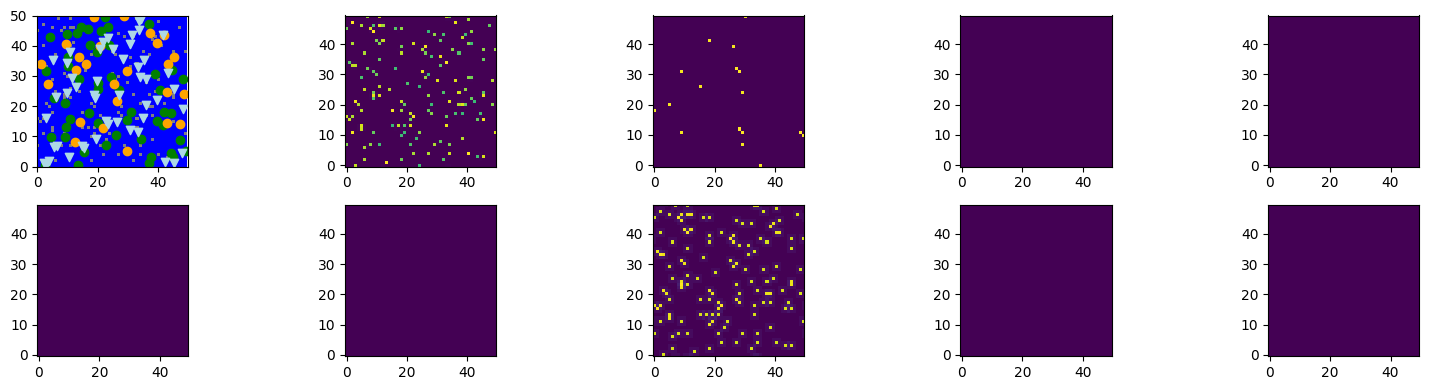

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(16,4))

model.plot_agents(axs[0,0])
model.plot_field(axs[0,1], field_name='extracellular_virus')
model.plot_field(axs[0,2], field_name='P_DAMPS')
model.plot_field(axs[0,3], field_name='ROS')
model.plot_field(axs[0,4], field_name='PAF')

model.plot_field(axs[1,0], field_name='TNF')
model.plot_field(axs[1,1], field_name='IL1')
model.plot_field(axs[1,2], field_name='IL18')
model.plot_field(axs[1,3], field_name='IL2')
model.plot_field(axs[1,4], field_name='IL4')

for r,c in itertools.product(range(2),range(5)):
    axs[r,c].set_aspect(1)
fig.tight_layout()
fig.show()

/tmp/ipykernel_527449/1356550103.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


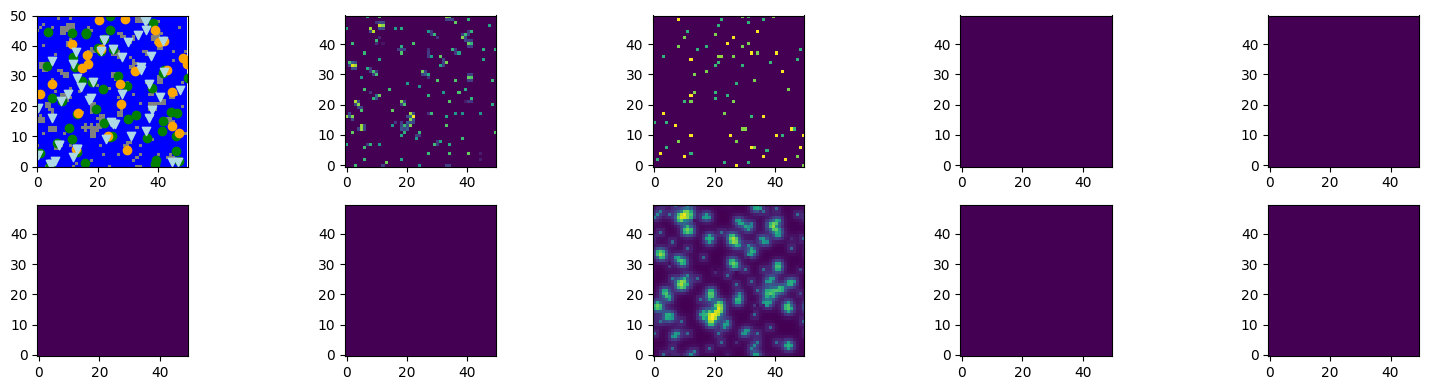

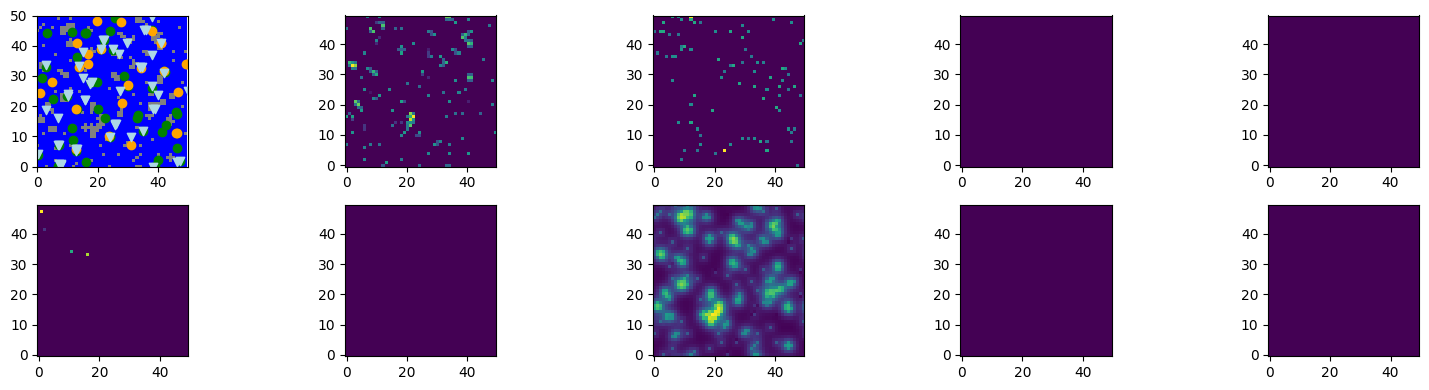

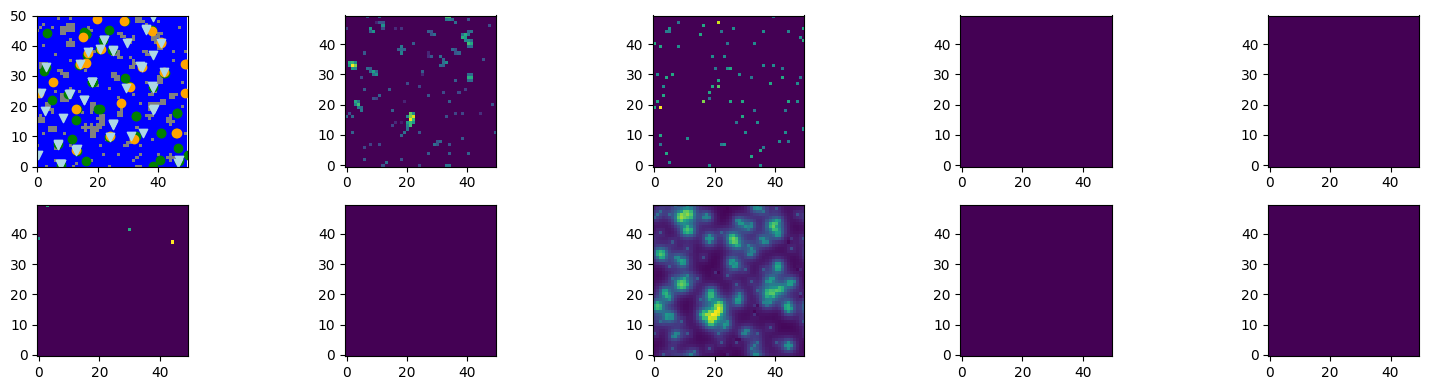

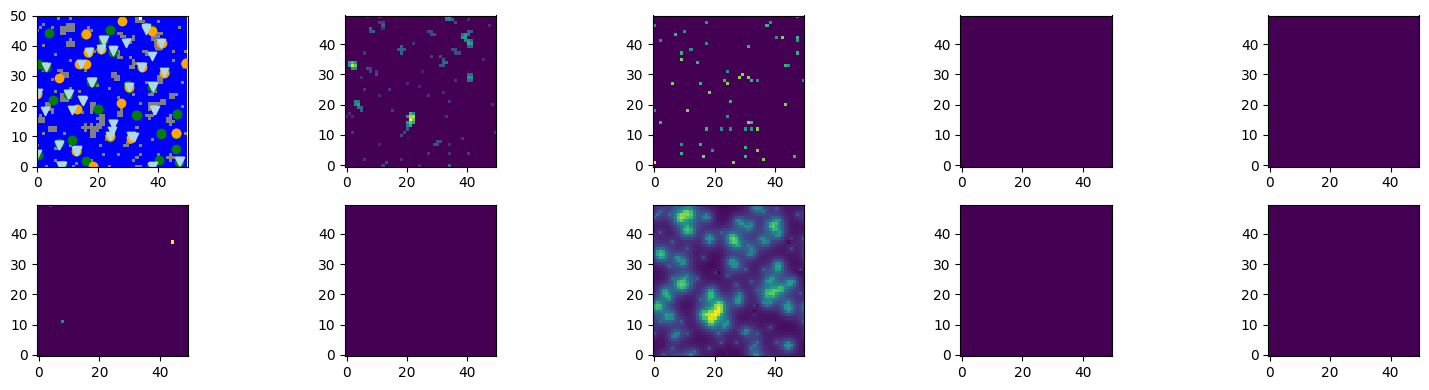

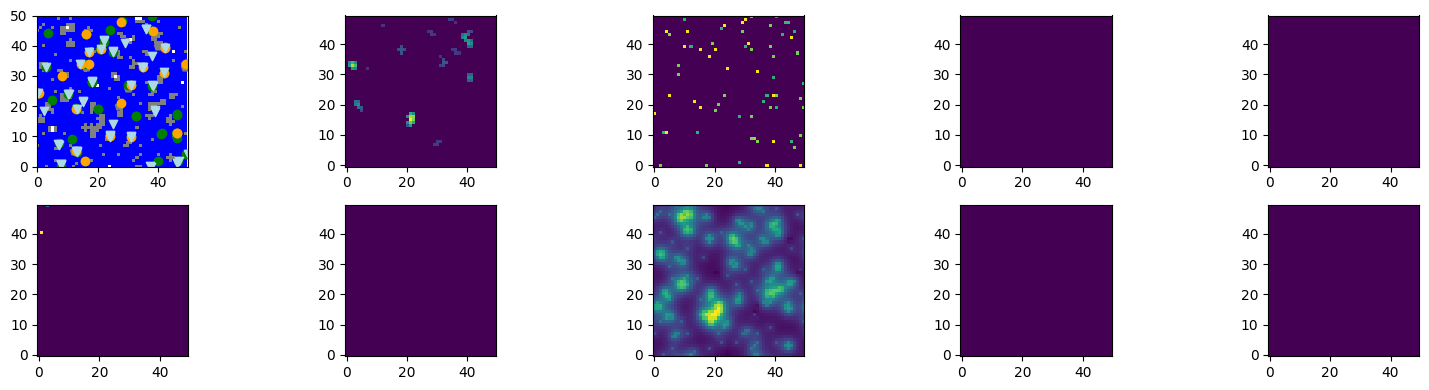

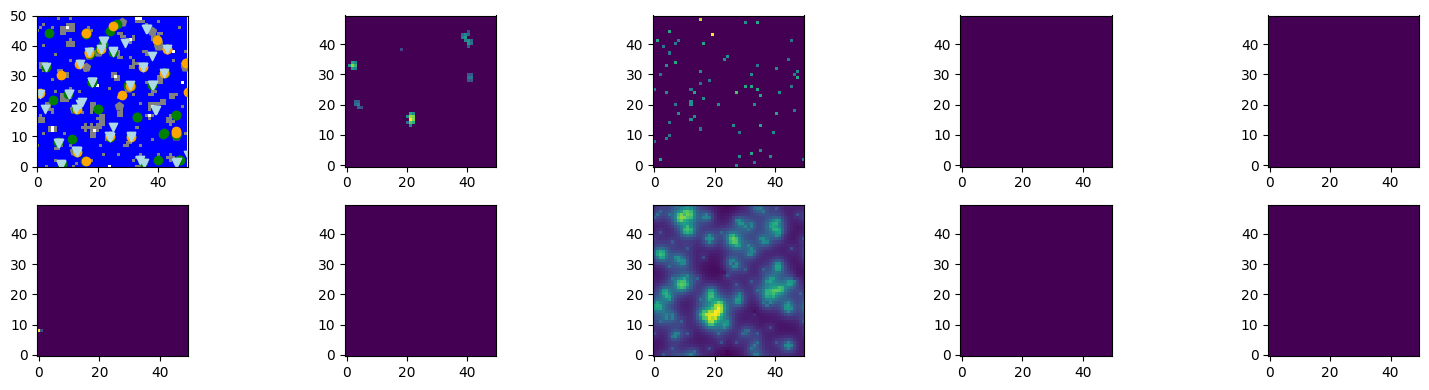

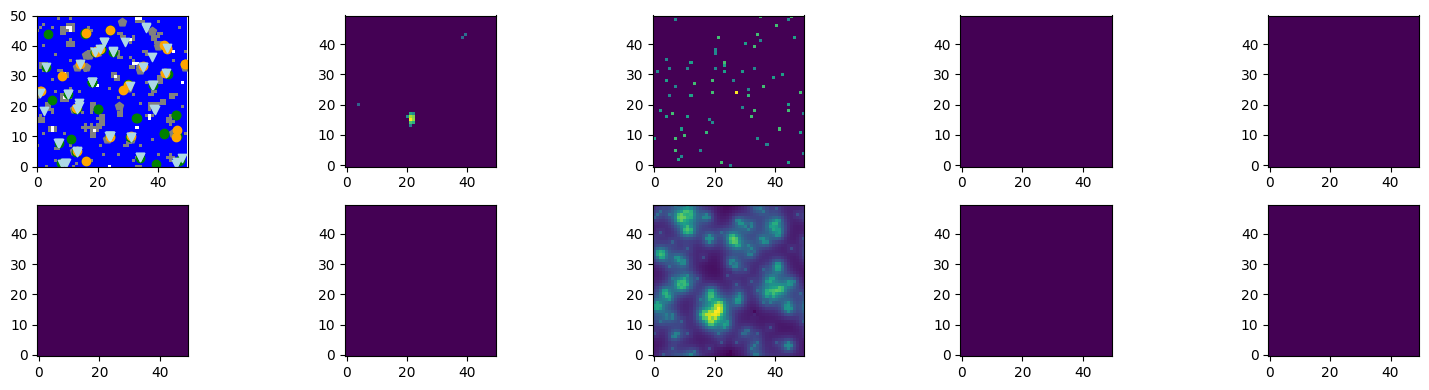

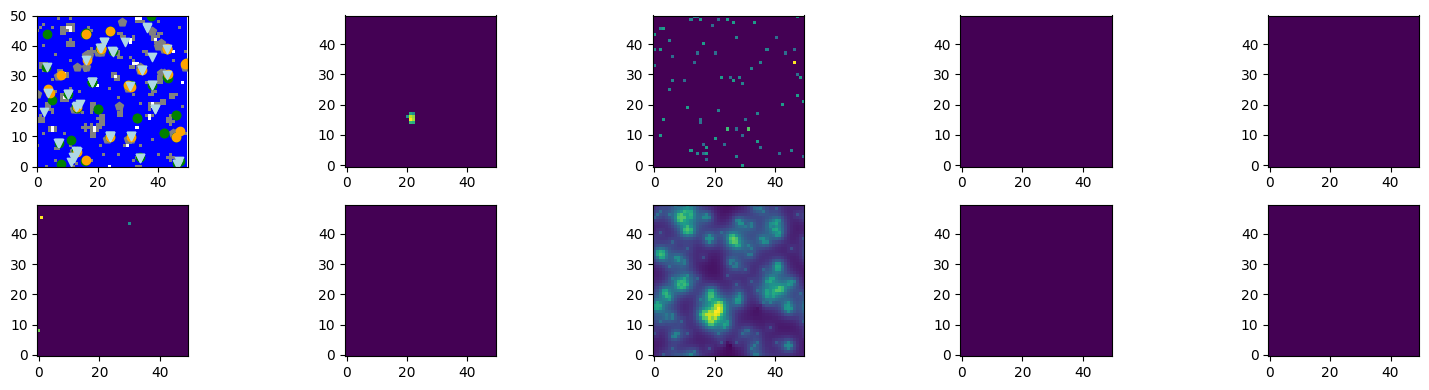

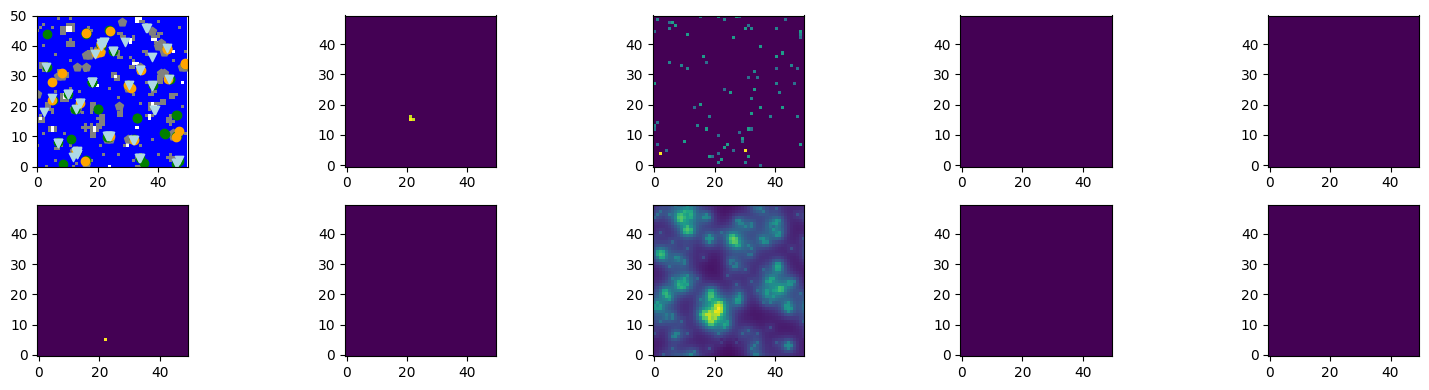

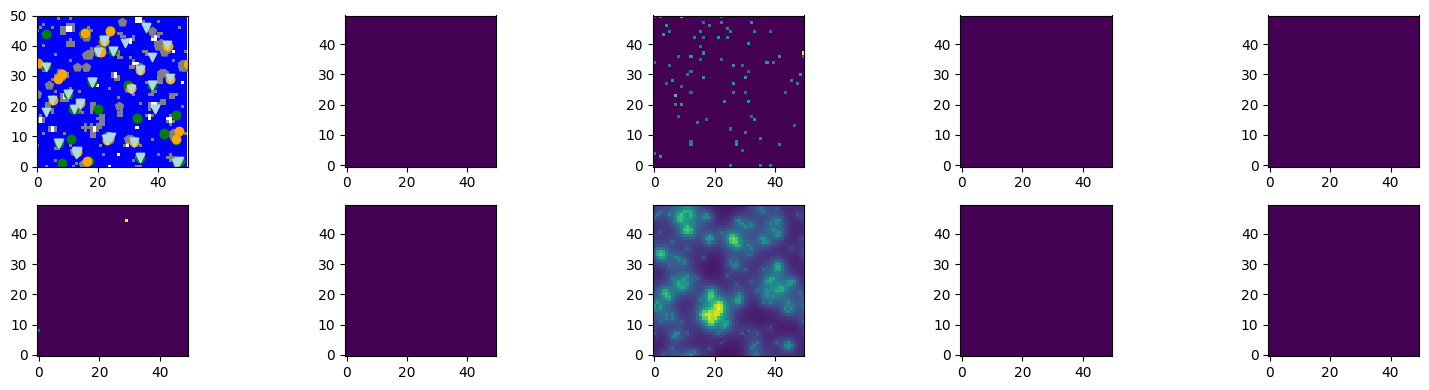

In [8]:
for _ in range(10):

    for __ in range(20):
        model.time_step()
    
    fig, axs = plt.subplots(2, 5, figsize=(16,4))
    
    model.plot_agents(axs[0,0])
    model.plot_field(axs[0,1], field_name='extracellular_virus')
    model.plot_field(axs[0,2], field_name='P_DAMPS')
    model.plot_field(axs[0,3], field_name='ROS')
    model.plot_field(axs[0,4], field_name='PAF')
    
    model.plot_field(axs[1,0], field_name='TNF')
    model.plot_field(axs[1,1], field_name='IL1')
    model.plot_field(axs[1,2], field_name='IL18')
    model.plot_field(axs[1,3], field_name='IL2')
    model.plot_field(axs[1,4], field_name='IL4')
    
    for r,c in itertools.product(range(2),range(5)):
        axs[r,c].set_aspect(1)
    fig.tight_layout()
    fig.show()

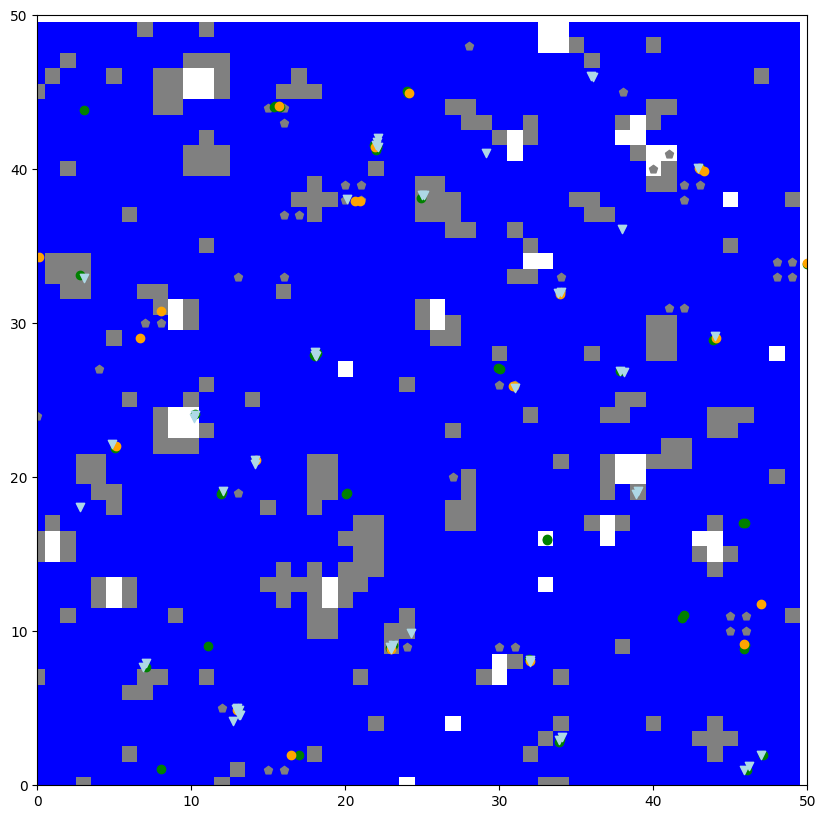

In [9]:
fig = plt.figure(figsize=(10,10))
ax=plt.gca()
model.plot_agents(ax)

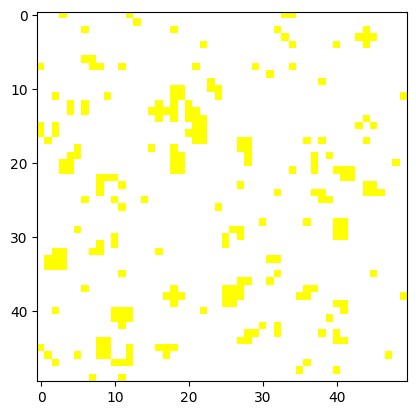

In [10]:
plt.imshow(
            model.epithelium.astype(int),
            cmap=matplotlib.colors.ListedColormap(
                np.array([
                    (0.0, 0.0, 0.0, 0.0),
                    matplotlib.colors.to_rgba("blue"),
                    matplotlib.colors.to_rgba("yellow"),
                    matplotlib.colors.to_rgba("grey"),
                    (0.0, 0.0, 0.0, 0.0),
                    (0.0, 0.0, 0.0, 0.0),
                ])
            ),
            zorder=-1,
        )


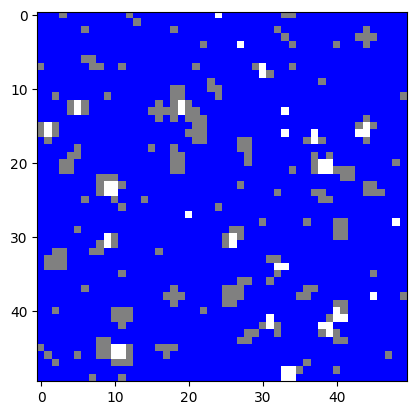

In [11]:
plt.imshow(
            model.epithelium.astype(float),
            cmap=matplotlib.colors.ListedColormap(
                np.array([
                    (0.0, 0.0, 0.0, 1.0),
                    matplotlib.colors.to_rgba("blue"),
                    matplotlib.colors.to_rgba("yellow"),
                    matplotlib.colors.to_rgba("grey"),
                    (0.0, 0.0, 0.0, 0.0),
                    (0.0, 0.0, 0.0, 0.0),
                ])
            ),
            vmin=0,
            vmax=4,
            zorder=-2,
        )


In [12]:
model.epithelium.astype(np.float64)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 2., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

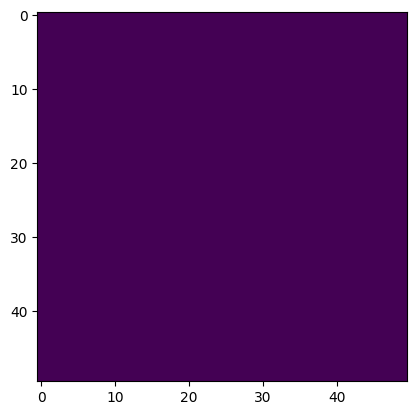

In [13]:
plt.imshow(
            model.epithelium == 3
        )
